In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import pandas as pd
from datetime import datetime, timedelta

# Add src directory to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src import config
from src.data_utils import transform_ts_data_info_features_and_target, split_time_series_data
import hopsworks


In [2]:
project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME,
    api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()

# Load feature group
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

# Create feature view (only once)
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"✅ Created feature view: {config.FEATURE_VIEW_NAME}")
except Exception as e:
    print(f"⚠️ Skipping feature view creation: {e}")

# Load feature view
feature_view = feature_store.get_feature_view(
    name=config.FEATURE_VIEW_NAME,
    version=config.FEATURE_VIEW_VERSION,
)


2025-05-10 11:15:28,718 INFO: Initializing external client
2025-05-10 11:15:28,721 INFO: Base URL: https://c.app.hopsworks.ai:443




To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'


2025-05-10 11:15:30,744 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215665
⚠️ Skipping feature view creation: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1215665/featurestores/1203294/featureview). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":270179,"usrMsg":"Feature view: citibike_hourly_features_view, version: 1","errorMsg":"The provided feature view name and version already exists"}', error code: 270179, error msg: The provided feature view name and version already exists, user msg: Feature view: citibike_hourly_features_view, version: 1


In [3]:
ts_data, _ = feature_view.training_data(description="Time-series hourly Citi Bike rides")
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.28s) 


In [4]:
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # remove timezone
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # e.g., 2025-03


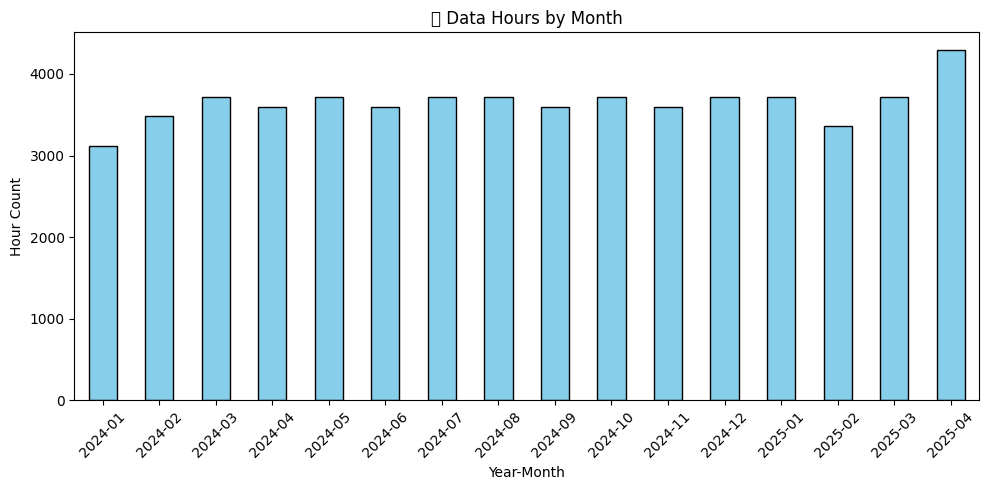

In [5]:
import matplotlib.pyplot as plt

month_counts = ts_data.groupby("year_month").size()
ax = month_counts.plot(kind="bar", figsize=(10, 5), color="skyblue", edgecolor="black")
ax.set_title("🕒 Data Hours by Month")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Hour Count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()


In [6]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58416 entries, 0 to 58415
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pickup_hour         58416 non-null  datetime64[ns]
 1   pickup_location_id  58416 non-null  object        
 2   rides               58416 non-null  int64         
 3   year_month          58416 non-null  period[M]     
dtypes: datetime64[ns](1), int64(1), object(1), period[M](1)
memory usage: 1.8+ MB


In [7]:
# ts_data = ts_data[(ts_data["year_month"] >= pd.Period("2025-02")) & 
#                   (ts_data["year_month"] <= pd.Period("2025-04"))].reset_index(drop=True)

ts_data.drop(columns=["year_month"], inplace=True)


In [8]:
features, targets = transform_ts_data_info_features_and_target(
    ts_data, window_size=24*28, step_size=23  # 28-day window, 1-hour step
)
features_targets = features.copy()
features_targets["target"] = targets


In [17]:
features_targets.head()

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,target,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,2024-02-03 00:00:00,HB101
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-02-03 23:00:00,HB101
2,0,0,0,0,0,0,0,0,1,6,...,0,0,0,0,0,0,0,0,2024-02-04 22:00:00,HB101
3,3,1,0,4,5,4,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-02-05 21:00:00,HB101
4,8,6,4,3,0,0,0,0,0,0,...,1,4,5,8,4,7,7,3,2024-02-06 20:00:00,HB101


In [9]:
cutoff_date = pd.Timestamp("2025-04-05")

X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print("X_train:", X_train.shape, "| X_test:", X_test.shape)


X_train: (2350, 674) | X_test: (161, 674)


In [10]:
from src.pipeline_utils import get_pipeline

best_parameters = {
    "bagging_fraction": 0.7, "bagging_freq": 1, "colsample_bytree": 0.6,
    "feature_fraction": 0.6, "learning_rate": 0.05, "max_depth": 30,
    "n_estimators": 200, "num_leaves": 256, "reg_alpha": 1.0, "reg_lambda": 0.1
}

pipeline = get_pipeline(**best_parameters)
pipeline.fit(X_train, y_train)


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22186
[LightGBM] [Info] Number of data points in the train set: 2350, number of used features: 675
[LightGBM] [

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x000002577AF6BF60>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor',
                 LGBMRegressor(bagging_fraction=0.7, bagging_freq=1,
                               colsample_bytree=0.6, feature_fraction=0.6,
                               learning_rate=0.05, max_depth=30,
                               n_estimators=200, num_leaves=256, reg_alpha=1.0,
                               reg_lambda=0.1))])

In [11]:
from sklearn.metrics import mean_absolute_error

preds = pipeline.predict(X_test)
test_mae = mean_absolute_error(y_test, preds)
print(f"📉 Test MAE: {test_mae:.4f}")


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
📉 Test MAE: 1.9779


In [12]:
import joblib  


# Save the pipeline  
joblib.dump(pipeline, config.MODELS_DIR / "citi_ride_lgb_model.pkl")

['C:\\Users\\Yaseen\\Desktop\\courses\\UB\\Spring25\\CDA500\\sp25_citi_bike-main\\models\\citi_ride_lgb_model.pkl']

In [13]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [14]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="citi_bike_ride_predictor",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor with hyper parameters",
    input_example=features.sample(),
    model_schema=model_schema
    # include_files=["src/", "requirements.txt"]  # Include directories and files
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
# model.save(config.MODELS_DIR / 'lgb_model.pkl')
model.save('C:\\Users\\Yaseen\\Desktop\\courses\\UB\\Spring25\\CDA500\\sp25_citi_bike-main\\models\\citi_ride_lgb_model.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/1021884 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2062 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/51397 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1215665/models/citi_bike_ride_predictor/1


Model(name: 'citi_bike_ride_predictor', version: 1)

In [15]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

2025-05-10 11:27:52,673 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-05-10 11:27:52,684 INFO: Initializing external client
2025-05-10 11:27:52,686 INFO: Base URL: https://c.app.hopsworks.ai:443




To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'


2025-05-10 11:27:53,949 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215665


In [16]:
from src.inference import get_model_predictions

In [ ]:
preds = get_model_predictions(model, features_copy)